In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,46712,None,None,85805.182677
2020-06-13,46713,None,None,79695.503776
2020-06-14,46714,None,None,74029.424884
2020-06-15,46715,None,None,68690.927143
2020-06-16,46716,None,None,63933.649059
...,...,...,...,...
2021-04-08,47012,None,None,45465.450340
2021-04-09,47013,None,None,43073.849596
2021-04-10,47014,None,None,40863.365959


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-12_2021-04-12-20-27.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-04-11_2021-04-11-17-19.pickle


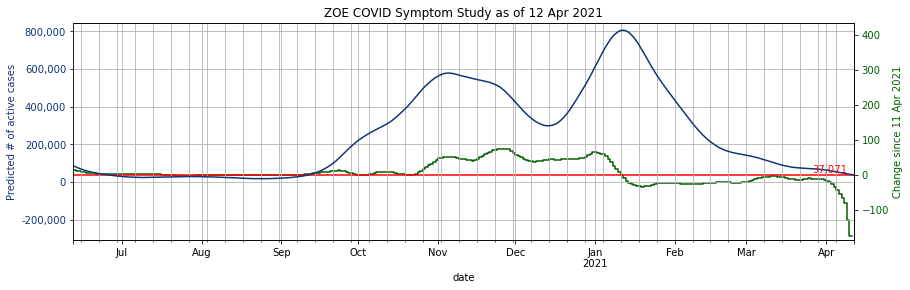

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

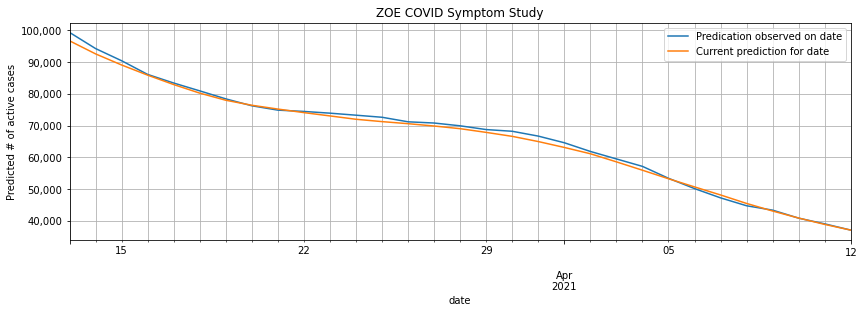

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-04-12_2021-04-12-20-27.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
301,Calderdale,E08000033,0.794400
294,Walsall,E08000030,0.592381
285,South Tyneside,E08000023,0.521209
122,Castle Point,E07000069,0.421698
390,Dundee City,S12000042,0.385854
381,Rhondda Cynon Taf,W06000016,0.266442
313,Aberdeen City,S12000033,0.224156
190,Lincoln,E07000138,0.189993
2,Redcar and Cleveland,E06000003,0.161853
291,Sandwell,E08000028,0.159638
